<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Reduce_effects_variability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Reduce_effects_variability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bifocal Stimulation: Reducing Neural Response Variability

This notebook analyzes how bifocal (dual-region) stimulation can reduce response variability compared to single-region stimulation, and compares it to closed-loop state-dependent stimulation approaches.

In [1]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 366 (delta 82), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (366/366), 40.32 MiB | 26.64 MiB/s, done.
Resolving deltas: 100% (123/123), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


## 2. Compute Bifocal Effective Connectivity (BECt)

Compute bifocal effective connectivity for all subjects using trained surrogate models.


In [ ]:
# # --- 8️⃣ Main BEC(t) extraction loop ---
# pert_strength = 0.1
# BECts = {}

# for sid in subjects:
#     print(f"\n================ {sid} ================")

#     sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
#     inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
#     tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
#     mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

#     if not os.path.exists(sig_path) or not os.path.exists(mdl_path):
#         print(f"❌ Missing data or model for {sid}")
#         continue

#     # Load fMRI windows
#     Z = np.load(sig_path)             # (T, N)
#     X = np.load(inp_path)             # (M, S*N)
#     Y = np.load(tgt_path)             # (M, N)

#     # Load model
#     model = load_model(mdl_path, X, Y)
#     print("🧩 Model loaded.")

#     # Compute EC(t)
#     BEC_t = NPI.model_BECt(model, input_X=X[:500,:], target_Y=Y[:500,:], pert_strength=pert_strength, metric='l2')
#     BECts[sid] = BEC_t
#     print(f"✅ BEC(t) computed: {BEC_t.shape}")

#     # Save
#     out_path = os.path.join(ects_dir, f"{sid}_BECt.npy")
#     np.save(out_path, BEC_t)
#     print(f"💾 Saved BEC(t) → {out_path}")

#     del Z, X, Y, model, BEC_t
#     gc.collect(); torch.cuda.empty_cache()

# print("\n🎯 All subjects processed successfully.")


================ id_100206 ================
🧩 Model loaded.
✅ BEC(t) computed: (500, 450, 450)
💾 Saved BEC(t) → /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP/id_100206_BECt.npy

================ id_100307 ================
🧩 Model loaded.


KeyboardInterrupt: 

In [2]:
# --- 8️⃣ Main BEC(t) extraction loop ---
pert_strength = 0.1
BECts = {}

# --- 9️⃣ Load previously saved BECt files ---
print("Loading previously computed BECt files...")
print(f"Looking in: {ects_dir}\n")

BECts_loaded = {}
for fn in os.listdir(ects_dir):
    if fn.endswith("_BECt.npy"):
        sid = fn.replace("_BECt.npy", "")
        path = os.path.join(ects_dir, fn)
        try:
            BEC_t = np.load(path)
            BECts_loaded[sid] = BEC_t
            print(f"✓ Loaded {sid}: shape {BEC_t.shape}")
        except Exception as e:
            print(f"✗ Failed to load {sid}: {e}")

# Merge with newly computed (newly computed take precedence if duplicate)
BECts.update(BECts_loaded)

print(f"\n📊 Total BECt matrices available: {len(BECts)}")
print(f"   From computation: {len([k for k in BECts.keys() if k in locals().get('subjects', [])])}")
print(f"   From disk: {len(BECts_loaded)}")
if len(BECts) == 0:
    print("⚠️  No BECt data available. Run computation cell above or check ects_dir path.")

Loading previously computed BECt files...
Looking in: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects/ECts_MLP

✓ Loaded id_100206: shape (500, 450, 450)

📊 Total BECt matrices available: 1
   From computation: 1
   From disk: 1


In [3]:
sid=list(BECts.keys())[0]
sid

'id_100206'

## 3. Functional Connectivity

FC for first participant

In [4]:
# Single subject plots
sig_path = os.path.join(preproc_dir, f"{sid}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{sid}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{sid}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{sid}_MLP.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)
S=3 #number of steps
N=Z.shape[1] #number of regions
Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=4600, noise_strength=0.1)

# Empirical vs simulated time series, FC

test_dur=3000

emp=Z[-test_dur:,:]
sim=Zsim[-test_dur:,:]

FC_emp=np.corrcoef(emp.T)
FC_sim=np.corrcoef(sim.T)

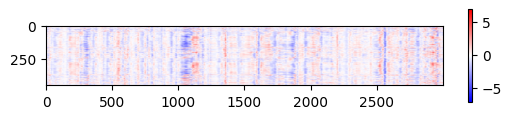

In [5]:
plt.imshow(sim.T,cmap='bwr')
plt.colorbar(shrink=0.25)

In [6]:
sim.shape

(3000, 450)

In [7]:
# ============================================================
# Pairwise ΦID Synergy/Redundancy matrices from sim (T x N)
# using OmegaID in Google Colab
#
# INPUT:
#   sim : np.ndarray of shape (T, N)  (time x ROIs), ideally z-scored
#
# OUTPUT:
#   Syn : (N, N) synergy matrix  (OmegaID atom 'sts')
#   Red : (N, N) redundancy matrix (OmegaID atom 'rtr')
#
# NOTES:
# - Uses threading backend (more stable in Colab than multiprocessing).
# - Auto-detects whether OmegaID atoms are scalar/per-time/per-component,
#   and chooses a reducer accordingly (mean vs sum vs identity).
# - Includes an optional validation: sum(atoms) ≈ TDMI (Gaussian MI past↔future).
# ============================================================

# ---------- 0) Install deps (Colab) ----------
!pip -q install omegaid joblib tqdm numpy scipy

# ---------- 1) Imports ----------
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from omegaid.core.decomposition import calc_phiid_multivariate


# ---------- 2) Basic checks ----------
def _check_sim(sim: np.ndarray):
    sim = np.asarray(sim, dtype=float)
    if sim.ndim != 2:
        raise ValueError(f"`sim` must be 2D (T,N). Got shape={sim.shape}")
    T, N = sim.shape
    if T < 3 or N < 2:
        raise ValueError(f"`sim` too small. Got T={T}, N={N}")
    return sim


# ---------- 3) Reducer auto-detection ----------
def _choose_reducer_from_atoms(atoms, T: int, tau: int, key="sts", verbose=True):
    """
    Decide how to turn atoms[key] into a scalar:
      - scalar -> identity
      - length == T - tau -> mean over time
      - otherwise -> sum (assume per-component/features)
    """
    arr = np.asarray(atoms[key]).squeeze()
    expected_timepoints = T - tau

    if verbose:
        print(f"[INFO] Atom '{key}' raw shape: {np.asarray(atoms[key]).shape}")
        print(f"[INFO] Expected per-timepoint length: {expected_timepoints} (T={T}, tau={tau})")

    if arr.ndim == 0:
        if verbose:
            print("[INFO] Atoms are scalars -> reducer = identity")
        return lambda x: float(np.asarray(x).squeeze())
    if arr.ndim == 1 and arr.shape[0] == expected_timepoints:
        if verbose:
            print("[INFO] Atoms are per-timepoint -> reducer = mean")
        return lambda x: float(np.mean(np.asarray(x).squeeze()))
    if verbose:
        print("[INFO] Atoms look per-component/features -> reducer = sum")
    return lambda x: float(np.sum(np.asarray(x).squeeze()))


# ---------- 4) Optional validation: sum(atoms) ≈ TDMI ----------
def _gaussian_mi(X, Y):
    """
    Gaussian mutual information I(X;Y) in bits.
    X: (dx, T_eff), Y: (dy, T_eff)
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)
    Z = np.vstack([X, Y])

    C = np.cov(Z, bias=False)
    dx = X.shape[0]

    Cx = C[:dx, :dx]
    Cy = C[dx:, dx:]
    det = np.linalg.det

    # numeric safety
    eps = 1e-12
    Cx = Cx + np.eye(Cx.shape[0]) * eps
    Cy = Cy + np.eye(Cy.shape[0]) * eps
    C  = C  + np.eye(C.shape[0])  * eps

    mi_nats = 0.5 * np.log(det(Cx) * det(Cy) / det(C))
    return float(mi_nats / np.log(2))

def validate_reducer(sim, tau, reducer, i=0, j=1, verbose=True):
    """
    Checks whether sum(reduced atoms) matches Gaussian TDMI for one pair.
    """
    T, N = sim.shape
    if j >= N:
        raise ValueError("Choose i,j within ROI range.")

    sources = np.vstack([sim[:, i], sim[:, j]])  # (2, T)
    atoms, extras = calc_phiid_multivariate(sources, sources, tau=tau)

    atoms_scalar = {k: reducer(v) for k, v in atoms.items()}
    atom_sum = sum(atoms_scalar.values())

    Xpast = sources[:, :-tau]
    Xfut  = sources[:, tau:]
    tdmi = _gaussian_mi(Xpast, Xfut)

    if verbose:
        print("\n[VALIDATION] TDMI vs sum(atoms)")
        print("TDMI (bits):      ", tdmi)
        print("sum(atoms) (bits):", atom_sum)
        print("difference:       ", atom_sum - tdmi)

    return tdmi, atom_sum, atoms_scalar


# ---------- 5) Main computation ----------
def compute_syn_red_matrices_omegaid(
    sim: np.ndarray,
    tau: int = 1,
    n_jobs: int = 2,          # In Colab, 2–4 is usually best
    backend: str = "threading",
    verbose: bool = True,
    run_validation: bool = True,
):
    """
    Compute Synergy (Syn) and Redundancy (Red) matrices:
      Syn[i,j] = reducer(atoms['sts'])
      Red[i,j] = reducer(atoms['rtr'])

    Returns:
      Syn, Red, reducer
    """
    sim = _check_sim(sim)
    T, N = sim.shape
    if not (1 <= tau < T):
        raise ValueError(f"tau must be in [1, T-1]. Got tau={tau} with T={T}")

    # Probe one pair to learn atom shapes + pick reducer
    if verbose:
        print("[INFO] Using ΦID backend: omegaid")
    probe = np.vstack([sim[:, 0], sim[:, 1]])
    atoms_probe, extras = calc_phiid_multivariate(probe, probe, tau=tau)

    # Ensure keys exist
    if "sts" not in atoms_probe or "rtr" not in atoms_probe:
        raise KeyError(f"Expected 'sts' and 'rtr' in atoms. Got keys: {list(atoms_probe.keys())}")

    reducer = _choose_reducer_from_atoms(atoms_probe, T=T, tau=tau, key="sts", verbose=verbose)

    if run_validation:
        # quick sanity check that decomposition sums to TDMI (should be close)
        validate_reducer(sim, tau=tau, reducer=reducer, i=0, j=1, verbose=verbose)

    Syn = np.zeros((N, N), dtype=float)
    Red = np.zeros((N, N), dtype=float)

    pairs = [(i, j) for i in range(N) for j in range(i + 1, N)]

    def _compute_pair(i, j):
        src = np.vstack([sim[:, i], sim[:, j]])
        atoms, extras = calc_phiid_multivariate(src, src, tau=tau)

        syn_val = reducer(atoms["sts"])
        red_val = reducer(atoms["rtr"])
        return i, j, syn_val, red_val

    if verbose:
        print(f"[INFO] Computing {len(pairs)} ROI pairs with tau={tau} using n_jobs={n_jobs} ({backend})")

    results = Parallel(n_jobs=n_jobs, backend=backend, verbose=0)(
        delayed(_compute_pair)(i, j) for (i, j) in tqdm(pairs, desc="ΦID pairs")
    )

    for i, j, syn_val, red_val in results:
        Syn[i, j] = Syn[j, i] = syn_val
        Red[i, j] = Red[j, i] = red_val

    np.fill_diagonal(Syn, 0.0)
    np.fill_diagonal(Red, 0.0)

    return Syn, Red, reducer


In [13]:

# ---------- 6) Run (YOU already have sim) ----------
# Example:
Syn, Red, reducer = compute_syn_red_matrices_omegaid(sim[:,:], tau=1, n_jobs=2, backend="threading", verbose=True)

# Save:
# np.save("Syn.npy", Syn)
# np.save("Red.npy", Red)

[INFO] Using ΦID backend: omegaid
[INFO] Atom 'sts' raw shape: (2999,)
[INFO] Expected per-timepoint length: 2999 (T=3000, tau=1)
[INFO] Atoms are per-timepoint -> reducer = mean

[VALIDATION] TDMI vs sum(atoms)
TDMI (bits):       5.649803076159006
sum(atoms) (bits): 3.9161450732414442
difference:        -1.7336580029175614
[INFO] Computing 101025 ROI pairs with tau=1 using n_jobs=2 (threading)


ΦID pairs:   0%|          | 0/101025 [00:00<?, ?it/s]

In [14]:
Syn.shape

(450, 450)

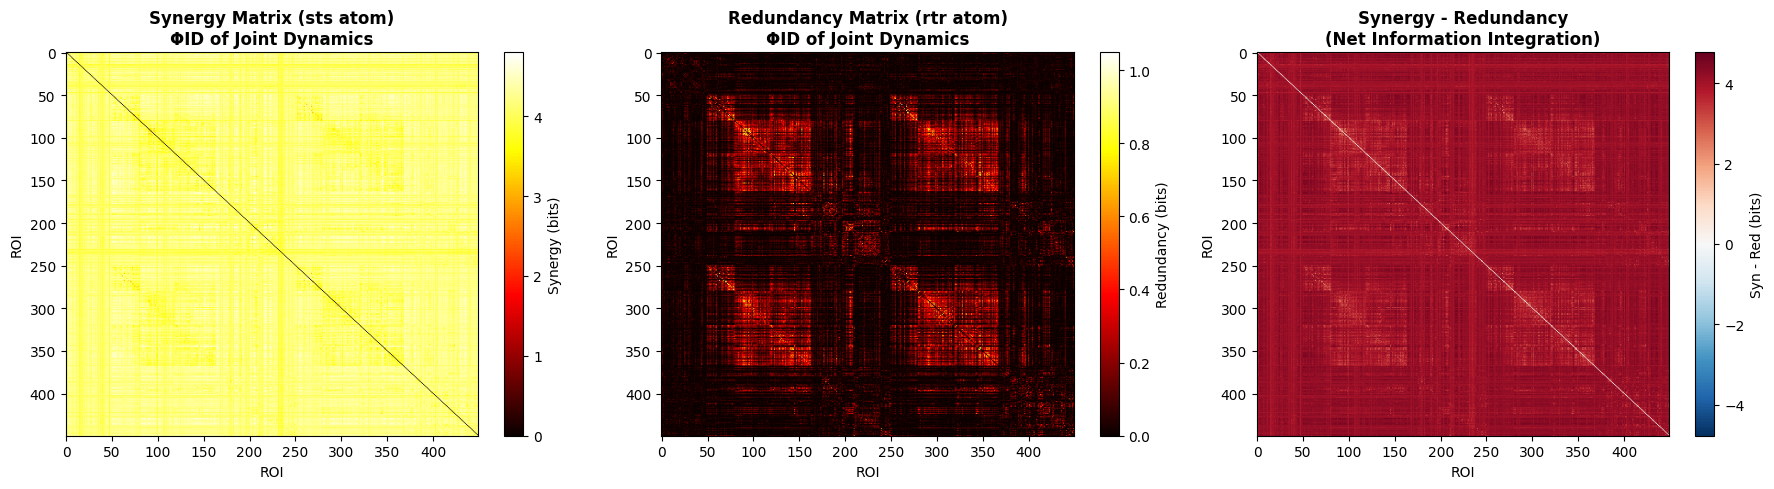

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Synergy
im1 = axes[0].imshow(Syn, cmap='hot', aspect='auto')
axes[0].set_title('Synergy Matrix (sts atom)\nΦID of Joint Dynamics',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('ROI')
axes[0].set_ylabel('ROI')
plt.colorbar(im1, ax=axes[0], label='Synergy (bits)')

# Redundancy
im2 = axes[1].imshow(Red, cmap='hot', aspect='auto')
axes[1].set_title('Redundancy Matrix (rtr atom)\nΦID of Joint Dynamics',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('ROI')
axes[1].set_ylabel('ROI')
plt.colorbar(im2, ax=axes[1], label='Redundancy (bits)')

# Synergy - Redundancy difference
diff = Syn - Red
im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
                     vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
axes[2].set_title('Synergy - Redundancy\n(Net Information Integration)',
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('ROI')
axes[2].set_ylabel('ROI')
plt.colorbar(im3, ax=axes[2], label='Syn - Red (bits)')

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def upper_triangle_values(M):
    """
    Extract upper-triangle (excluding diagonal) values from a symmetric matrix.
    """
    mask = np.triu(np.ones_like(M, dtype=bool), k=1)
    return M[mask]

# Extract edge vectors
fc_vals  = upper_triangle_values(FC_sim)
red_vals = upper_triangle_values(Red)
syn_vals = upper_triangle_values(Syn)

# Pearson correlations (as in the paper)
r_fc_red, p_fc_red = pearsonr(fc_vals, red_vals)
r_fc_syn, p_fc_syn = pearsonr(fc_vals, syn_vals)
r_red_syn, p_red_syn = pearsonr(red_vals, syn_vals)

print("Edge-wise Pearson correlations:")
print(f"corr(FC, Red) = {r_fc_red:.3f}, p = {p_fc_red:.2e}")
print(f"corr(FC, Syn) = {r_fc_syn:.3f}, p = {p_fc_syn:.2e}")
print(f"corr(Red, Syn) = {r_red_syn:.3f}, p = {p_red_syn:.2e}")

Edge-wise Pearson correlations:
corr(FC, Red) = 0.789, p = 0.00e+00
corr(FC, Syn) = -0.377, p = 0.00e+00
corr(Red, Syn) = -0.501, p = 0.00e+00


In [ ]:
# Save
#     out_path = os.path.join(ects_dir, f"{sid}_BECt.npy")
#     np.save(out_path, BEC_t)
#     print(f"💾 Saved BEC(t) → {out_path}")

## 4. Visualize Bifocal Variability Reduction

Heatmaps showing which region pairs most effectively reduce neural response variability.


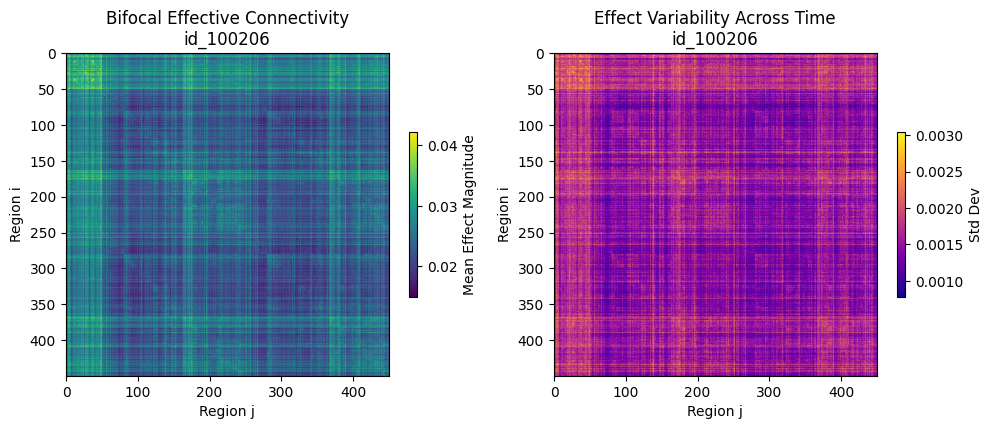

In [17]:
if len(BECts) > 0:
    # Analyze first subject for visualization
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]
    #analysis = analyze_bifocal_variability_reduction(BEC_t)
    mean_bec = np.mean(BEC_t, axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Heatmap 1: Mean bifocal effective connectivity
    im1 = axes[0].imshow(mean_bec, cmap='viridis')
    axes[0].set_title(f'Bifocal Effective Connectivity\n{first_sid}')
    axes[0].set_xlabel('Region j')
    axes[0].set_ylabel('Region i')
    plt.colorbar(im1, ax=axes[0], label='Mean Effect Magnitude',shrink=0.35)

    # Heatmap 2: Temporal variability (std across time)
    std_bec = np.std(BEC_t, axis=0)
    im2 = axes[1].imshow(std_bec, cmap='plasma')
    axes[1].set_title(f'Effect Variability Across Time\n{first_sid}')
    axes[1].set_xlabel('Region j')
    axes[1].set_ylabel('Region i')
    plt.colorbar(im2, ax=axes[1], label='Std Dev',shrink=0.35)

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'bifocal_heatmaps.png'), dpi=150, bbox_inches='tight')
    plt.show()

    #print(f"\n✓ Heatmaps generated for {first_sid}")
    #print(f"  Mean bifocal effect: {analysis['global_mean_effect']:.4f} ± {analysis['global_std_effect']:.4f}")
    #print(f"\n  Top 5 region pairs by bifocal effect:")
    #for rank, pair in enumerate(analysis['top_pairs'][:5], 1):
    #    print(f"    {rank}. Regions {pair['regions']}: {pair['mean_effect']:.4f} ± {pair['std_effect']:.4f}")
else:
    print("⚠️ No BECt data computed. Run cell above first.")


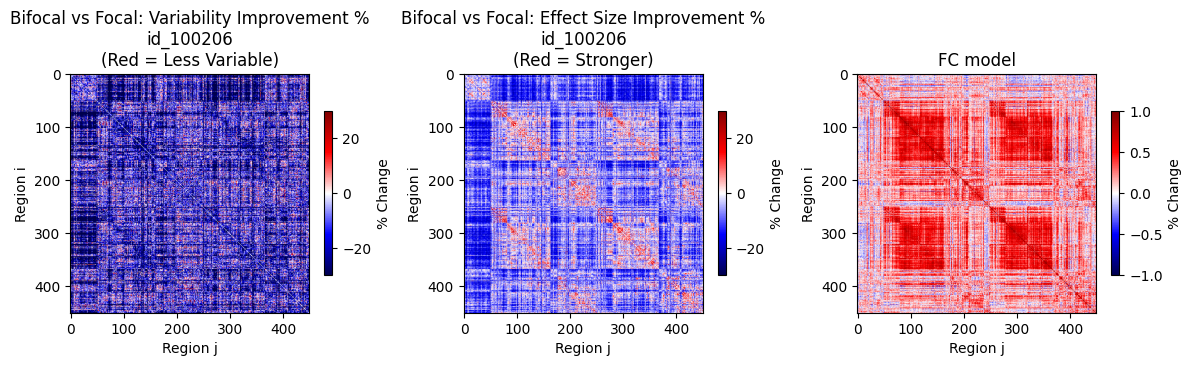


✓ Focal vs Bifocal improvement heatmaps generated for id_100206
  Left: Variability improvement (positive = bifocal is more stable than focal)
  Right: Effect size improvement (positive = bifocal is stronger than focal)


In [18]:
if len(BECts) > 0:
    # Compare bifocal (ij) to focal (ii, jj) stimulation
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]
    M, N, _ = BEC_t.shape

    # Extract statistics for focal and bifocal effects
    #focal_mean = np.array([np.mean(BEC_t[:, i, i]) for i in range(N)])  # (N,)
    #focal_std = np.array([np.std(BEC_t[:, i, i]) for i in range(N)])    # (N,)
    bifocal_mean = np.mean(BEC_t, axis=0)  # (N, N)
    bifocal_std = np.std(BEC_t, axis=0)    # (N, N)

    # Create improvement matrices
    var_improvement = np.zeros((N, N))      # (N, N)
    effect_improvement = np.zeros((N, N))   # (N, N)

    for i in range(N):
        for j in range(N):
            if i != j:
                # Variability improvement: -1 * (AB - min(A,B)) / min(A,B) * 100
                # Positive = better (less variable)
                var_A = bifocal_std[i, i]#focal_std[i]
                var_B = bifocal_std[j, j]#focal_std[j]
                var_AB = bifocal_std[i, j]
                var_min = min(var_A, var_B)

                if var_min > 1e-10:
                    var_improvement[i, j] = -1 * (var_AB - var_min) / var_min * 100
                else:
                    var_improvement[i, j] = np.nan

                # Effect size improvement: (AB - max(A,B)) / max(A,B) * 100
                # Positive = better (stronger)
                effect_A = np.abs(bifocal_mean[i, i])
                effect_B = np.abs(bifocal_mean[j, j])
                effect_AB = np.abs(bifocal_mean[i, j])
                effect_max = max(effect_A, effect_B)

                if effect_max > 1e-10:
                    effect_improvement[i, j] = (effect_AB - effect_max) / effect_max * 100
                else:
                    effect_improvement[i, j] = np.nan

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Heatmap 1: Variability improvement (negative = better)
    vmax_var = 30#np.nanmax(np.abs(var_improvement))
    im1 = axes[0].imshow(var_improvement, cmap='seismic',
                         vmin=-vmax_var, vmax=vmax_var)
    axes[0].set_title(f'Bifocal vs Focal: Variability Improvement %\n{first_sid}\n(Red = Less Variable)')
    axes[0].set_xlabel('Region j')
    axes[0].set_ylabel('Region i')
    cbar1 = plt.colorbar(im1, ax=axes[0], label='% Change',shrink=0.35)

    # Heatmap 2: Effect size improvement (positive = better)
    vmax_eff = 30#np.nanmax(np.abs(effect_improvement))
    im2 = axes[1].imshow(effect_improvement, cmap='seismic',
                         vmin=-vmax_eff, vmax=vmax_eff)
    axes[1].set_title(f'Bifocal vs Focal: Effect Size Improvement %\n{first_sid}\n(Red = Stronger)')
    axes[1].set_xlabel('Region j')
    axes[1].set_ylabel('Region i')
    cbar2 = plt.colorbar(im2, ax=axes[1], label='% Change',shrink=0.35)

    # Heatmap 3: Relative effect size improvement (positive = better)
    #var_improvement / effect_improvement

    vmax_eff = 1
    im3 = axes[2].imshow(FC_sim, cmap='seismic',
                         vmin=-vmax_eff, vmax=vmax_eff)
    axes[2].set_title(f'FC model')
    axes[2].set_xlabel('Region j')
    axes[2].set_ylabel('Region i')
    cbar3 = plt.colorbar(im3, ax=axes[2], label='% Change',shrink=0.35)

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'bifocal_vs_focal_improvement.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Focal vs Bifocal improvement heatmaps generated for {first_sid}")
    print(f"  Left: Variability improvement (positive = bifocal is more stable than focal)")
    print(f"  Right: Effect size improvement (positive = bifocal is stronger than focal)")
else:
    print("⚠️ No BECt data available.")

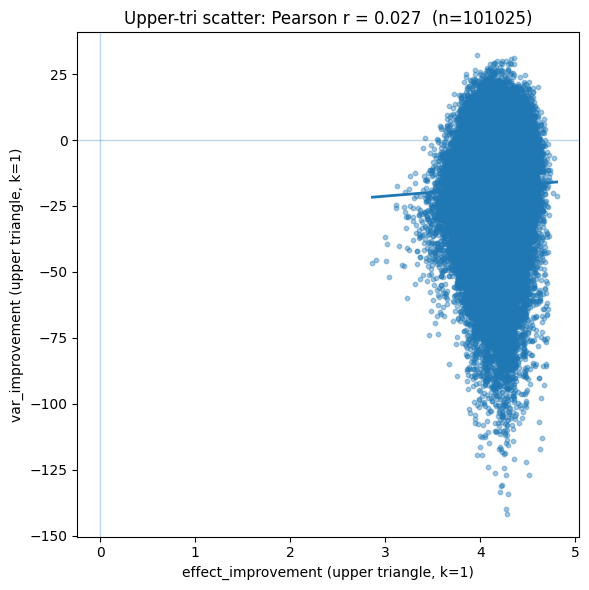

Pearson r = 0.027404
Regression: y = 2.96995 * x + -30.173


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Pull upper-triangular entries (exclude diagonal)
iu = np.triu_indices_from(FC_sim, k=1)

x = Syn[iu].astype(float)
y = var_improvement[iu].astype(float)

# 2) Drop NaNs/Infs (and anything invalid)
m = np.isfinite(x) & np.isfinite(y)
x = x[m]
y = y[m]

# 3) Pearson r
r = np.corrcoef(x, y)[0, 1]

# 4) Regression line: y = slope*x + intercept
slope, intercept = np.polyfit(x, y, 1)

# 5) Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, s=10, alpha=0.4)

# regression line over x-range
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, slope * xx + intercept, linewidth=2)

ax.set_xlabel("effect_improvement (upper triangle, k=1)")
ax.set_ylabel("var_improvement (upper triangle, k=1)")
ax.set_title(f"Upper-tri scatter: Pearson r = {r:.3f}  (n={len(x)})")

ax.axhline(0, linewidth=1, alpha=0.3)
ax.axvline(0, linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pearson r = {r:.6f}")
print(f"Regression: y = {slope:.6g} * x + {intercept:.6g}")



================ id_100206 ================
  Selected 50 timepoints from 500 total
  Random: 50 points
  Low energy: mean E = 480.6396
  High energy: mean E = 5081.8436


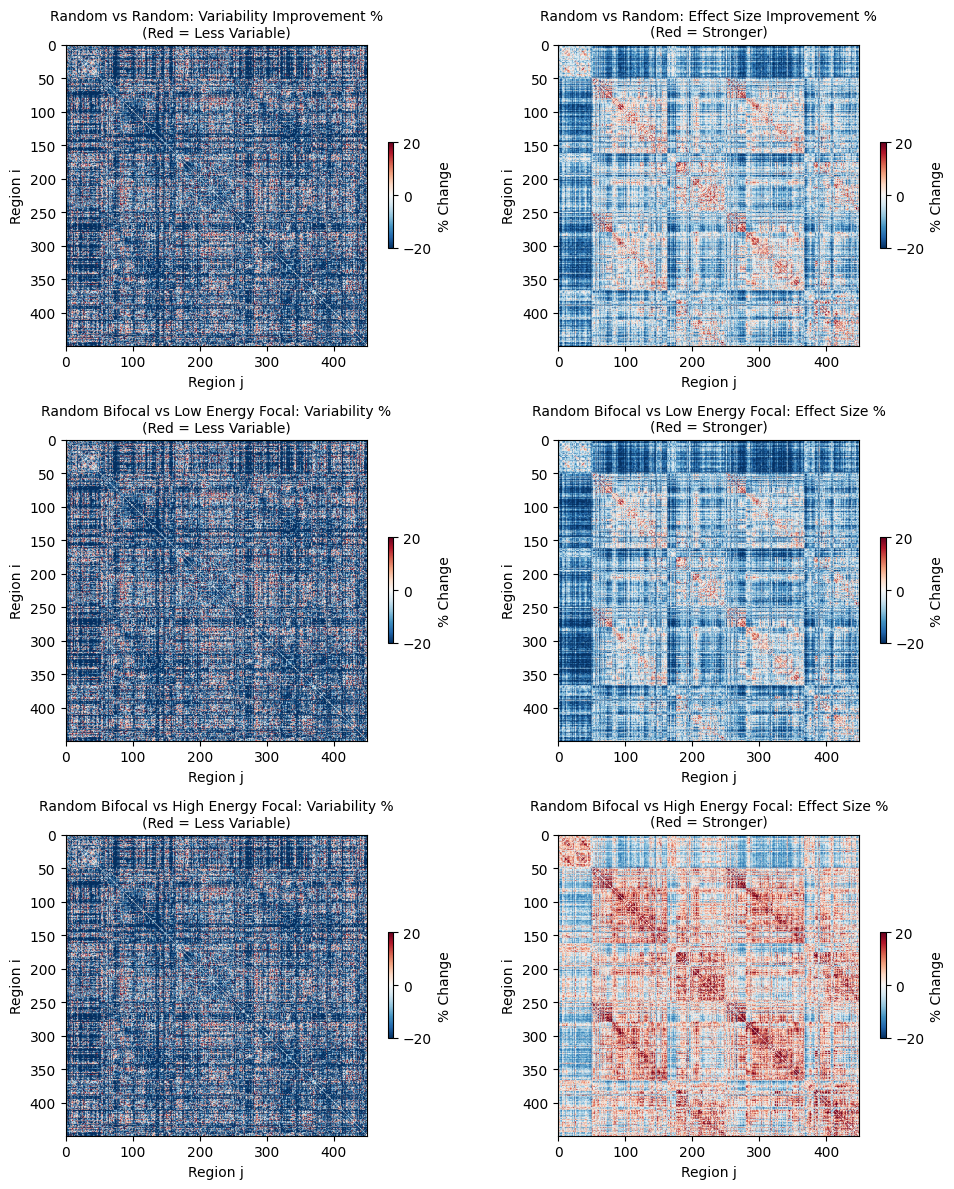


✓ Energy-dependent comparison heatmaps generated for id_100206
  Row 1: Random bifocal (10%) vs Random focal (10%)
  Row 2: Random bifocal (10%) vs Low energy focal (10%)
  Row 3: Random bifocal (10%) vs High energy focal (10%)


In [ ]:
# Fraction of timepoints to keep (10%)
frac = 0.1

if len(BECts) > 0:
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]

    print(f"\n================ {first_sid} ================")

    inp_path = os.path.join(preproc_dir, f"{first_sid}_inputs.npy")
    X = np.load(inp_path)  # (M, S*N)

    M, N, _ = BEC_t.shape
    S = X.shape[1] // N

    # --- Baseline energy
    x_t = X[:M, :]
    E_t = np.sum(x_t**2, axis=1)
    n_sel = int(frac * M)
    sorted_idx = np.argsort(E_t)
    low_idx = sorted_idx[:n_sel]
    high_idx = sorted_idx[-n_sel:]
    rngx = np.random.default_rng(seed=42)
    rand_idx = rngx.choice(M, size=n_sel, replace=False)
    rngy = np.random.default_rng(seed=4)
    rand_idy = rngy.choice(M, size=n_sel, replace=False)

    print(f"  Selected {n_sel} timepoints from {M} total")
    print(f"  Random: {len(rand_idx)} points")
    print(f"  Low energy: mean E = {np.mean(E_t[low_idx]):.4f}")
    print(f"  High energy: mean E = {np.mean(E_t[high_idx]):.4f}")

    # Function to compute improvements for a given time selection
    def compute_improvements(BEC_t, time_idx, time_idy, label=""):
        """Compute bifocal vs focal improvements for selected timepoints."""
        M, N, _ = BEC_t.shape

        # Extract at selected times
        focal_mean = np.array([np.mean(BEC_t[time_idx, i, i]) for i in range(N)])
        focal_std = np.array([np.std(BEC_t[time_idx, i, i]) for i in range(N)])
        bifocal_mean = np.mean(BEC_t[time_idy, :, :], axis=0)
        bifocal_std = np.std(BEC_t[time_idy, :, :], axis=0)

        var_improvement = np.zeros((N, N))
        effect_improvement = np.zeros((N, N))

        for i in range(N):
            for j in range(N):
                if i != j:
                    # Variability improvement
                    var_A = bifocal_std[i, i]
                    var_B = bifocal_std[j, j]
                    var_AB = bifocal_std[i, j]
                    var_min = min(var_A, var_B)

                    if var_min > 1e-10:
                        var_improvement[i, j] = -1 * (var_AB - var_min) / var_min * 100
                    else:
                        var_improvement[i, j] = np.nan

                    # Effect size improvement
                    effect_A = np.abs(focal_mean[i])
                    effect_B = np.abs(focal_mean[j])
                    effect_AB = np.abs(bifocal_mean[i, j])
                    effect_max = max(effect_A, effect_B)

                    if effect_max > 1e-10:
                        effect_improvement[i, j] = (effect_AB - effect_max) / effect_max * 100
                    else:
                        effect_improvement[i, j] = np.nan

        return var_improvement, effect_improvement

    # Compute improvements for all three focal conditions
    var_rand_rand, eff_rand_rand = compute_improvements(BEC_t, rand_idx, rand_idy, "random times")
    var_rand_low, eff_rand_low = compute_improvements(BEC_t, low_idx, rand_idy, "low energy times")
    var_rand_high, eff_rand_high = compute_improvements(BEC_t, high_idx, rand_idy, "high energy times")

    # Create 3x2 subplot figure
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))

    # Helper function to plot heatmap
    def plot_heatmap(ax, data, title, cbar_label='% Change'):
        vmax = 20#np.nanmax(np.abs(data))
        im = ax.imshow(data, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Region j')
        ax.set_ylabel('Region i')
        plt.colorbar(im, ax=ax, label=cbar_label,shrink=0.35)
        return im

    # Row 1: Random bifocal vs Random focal
    plot_heatmap(axes[0, 0], var_rand_rand,
                 f'Random vs Random: Variability Improvement %\n(Red = Less Variable)')
    plot_heatmap(axes[0, 1], eff_rand_rand,
                 f'Random vs Random: Effect Size Improvement %\n(Red = Stronger)')

    # Row 2: Random bifocal vs Low energy focal
    plot_heatmap(axes[1, 0], var_rand_low,
                 f'Random Bifocal vs Low Energy Focal: Variability %\n(Red = Less Variable)')
    plot_heatmap(axes[1, 1], eff_rand_low,
                 f'Random Bifocal vs Low Energy Focal: Effect Size %\n(Red = Stronger)')

    # Row 3: Random bifocal vs High energy focal
    plot_heatmap(axes[2, 0], var_rand_high,
                 f'Random Bifocal vs High Energy Focal: Variability %\n(Red = Less Variable)')
    plot_heatmap(axes[2, 1], eff_rand_high,
                 f'Random Bifocal vs High Energy Focal: Effect Size %\n(Red = Stronger)')

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'bifocal_vs_focal_energy_conditions.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Energy-dependent comparison heatmaps generated for {first_sid}")
    print(f"  Row 1: Random bifocal (10%) vs Random focal (10%)")
    print(f"  Row 2: Random bifocal (10%) vs Low energy focal (10%)")
    print(f"  Row 3: Random bifocal (10%) vs High energy focal (10%)")

    del X
else:
    print("⚠️ No BECt data available.")


================ FOCAL-ONLY PER-REGION ANALYSIS: id_100206 ================


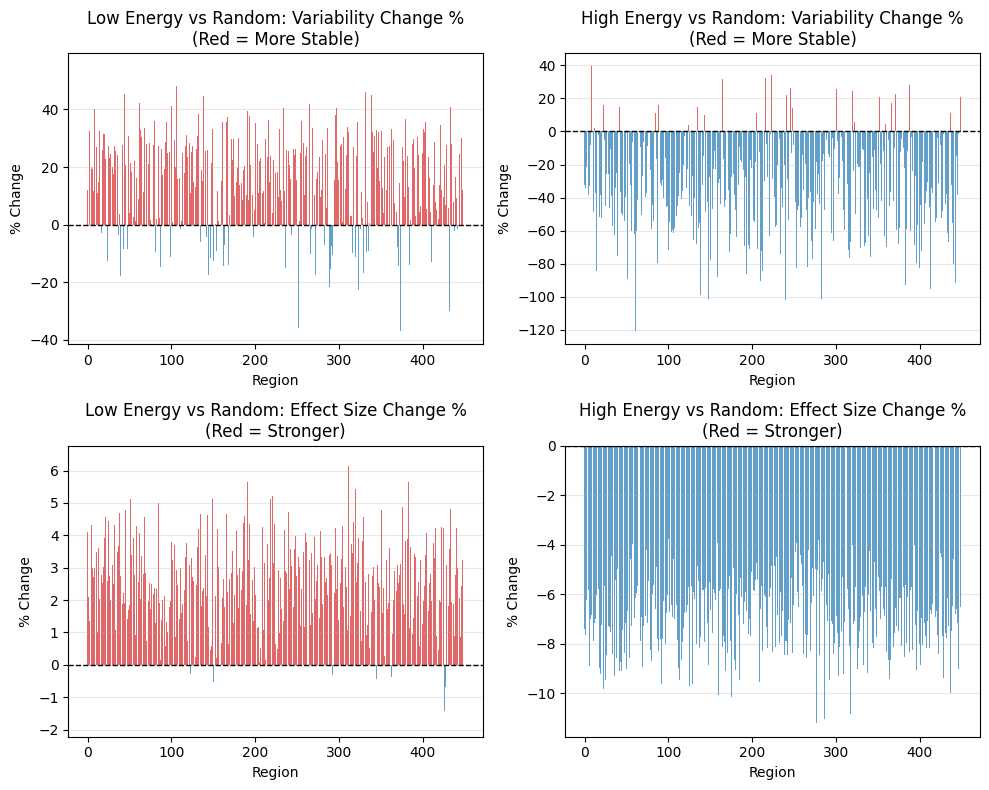

In [ ]:
# Focal-only comparison: Per-region variability and effect size
if len(BECts) > 0:
    first_sid = list(BECts.keys())[0]
    BEC_t = BECts[first_sid]

    print(f"\n================ FOCAL-ONLY PER-REGION ANALYSIS: {first_sid} ================")

    M, N, _ = BEC_t.shape

    # Compute per-region metrics for each time condition
    # Effect sizes: mean of diagonal values
    effect_rand = np.array([np.mean(BEC_t[rand_idx, i, i]) for i in range(N)])
    effect_low = np.array([np.mean(BEC_t[low_idx, i, i]) for i in range(N)])
    effect_high = np.array([np.mean(BEC_t[high_idx, i, i]) for i in range(N)])

    # Variabilities: std dev of diagonal values
    var_rand = np.array([np.std(BEC_t[rand_idx, i, i]) for i in range(N)])
    var_low = np.array([np.std(BEC_t[low_idx, i, i]) for i in range(N)])
    var_high = np.array([np.std(BEC_t[high_idx, i, i]) for i in range(N)])

    # Calculate percent changes
    # Variability changes
    var_change_low = -1 * (var_low - var_rand) / (var_rand + 1e-10) * 100   # (N,)
    var_change_high = -1 * (var_high - var_rand) / (var_rand + 1e-10) * 100

    # Effect size changes
    effect_change_low = (effect_low - effect_rand) / (np.abs(effect_rand) + 1e-10) * 100
    effect_change_high = (effect_high - effect_rand) / (np.abs(effect_rand) + 1e-10) * 100

    # Create figure with 2×2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    regions = np.arange(N)

    # Plot 1: Variability change - Low energy
    axes[0, 0].bar(regions, var_change_low, color=['tab:blue' if x < 0 else 'tab:red' for x in var_change_low], alpha=0.7)
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 0].set_xlabel('Region')
    axes[0, 0].set_ylabel('% Change')
    axes[0, 0].set_title('Low Energy vs Random: Variability Change %\n(Red = More Stable)')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Variability change - High energy
    axes[0, 1].bar(regions, var_change_high, color=['tab:blue' if x < 0 else 'tab:red' for x in var_change_high], alpha=0.7)
    axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_xlabel('Region')
    axes[0, 1].set_ylabel('% Change')
    axes[0, 1].set_title('High Energy vs Random: Variability Change %\n(Red = More Stable)')
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Plot 3: Effect size change - Low energy
    axes[1, 0].bar(regions, effect_change_low, color=['tab:blue' if x < 0 else 'tab:red' for x in effect_change_low], alpha=0.7)
    axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_xlabel('Region')
    axes[1, 0].set_ylabel('% Change')
    axes[1, 0].set_title('Low Energy vs Random: Effect Size Change %\n(Red = Stronger)')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Effect size change - High energy
    axes[1, 1].bar(regions, effect_change_high, color=['tab:blue' if x < 0 else 'tab:red' for x in effect_change_high], alpha=0.7)
    axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 1].set_xlabel('Region')
    axes[1, 1].set_ylabel('% Change')
    axes[1, 1].set_title('High Energy vs Random: Effect Size Change %\n(Red = Stronger)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    #plt.savefig(os.path.join(project_root, 'focal_per_region_energy_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # # Print per-region statistics
    # print(f"\n📊 PER-REGION FOCAL COMPARISON:")
    # print(f"\n{'Region':<8} {'Var_rand':<10} {'Var_low':<10} {'Var_high':<10} {'VarChg_low%':<12} {'VarChg_high%':<12} {'Eff_rand':<10} {'Eff_low':<10} {'Eff_high':<10} {'EffChg_low%':<12} {'EffChg_high%':<12}")
    # print("-" * 130)
    # for i in range(N):
    #     print(f"{i:<8} {var_rand[i]:<10.4f} {var_low[i]:<10.4f} {var_high[i]:<10.4f} {var_change_low[i]:<12.2f} {var_change_high[i]:<12.2f} {effect_rand[i]:<10.4f} {effect_low[i]:<10.4f} {effect_high[i]:<10.4f} {effect_change_low[i]:<12.2f} {effect_change_high[i]:<12.2f}")

    # print(f"\n✓ Per-region focal energy comparison plots saved")
else:
    print("⚠️ No BECt data available.")

## 6. Summary: Bifocal Stimulation for Variability Reduction

Clinical implications and key findings from bifocal connectivity analysis.
